In [1]:
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring, bitstring_to_bytes, bitstring_to_int

In [2]:
import multihash as mh
import hashlib as hl  

def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

def xor_bitstring(bs0: str, bs1: str) -> str:
    s = ""
    if len(bs0) == len(bs1):
        for i in range(len(bs0)):
            if bs0[i]==bs1[i]:
                s+='0'
            else:
                s+='1'
    return s

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [3]:
import csv

filename = "nebula-peers-2.csv"

In [4]:
with open(filename, 'r') as file:
    all_nebula_peers = [line for line in csv.reader(file)]

In [5]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        if bytes_to_bitstring(peer.key) not in self.neighbors:
            self.neighbors[bytes_to_bitstring(peer.key)]=(peer)
            self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)
    

In [8]:
crawlid = all_nebula_peers[0][0]
peers_crawl0 = {line[1]: NebulaPeer(line[1], line[2], line[3:]) for line in all_nebula_peers if line[0] == crawlid}

In [196]:
alive_peers = {line[0]: NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers if len(line)>2}

ValueError: Invalid character '0'

In [197]:
# define neighbor relationships
for p in peers:
    for n in peers[p].neighbors_ids:
        peers[p].addNeighbor(peers[n])

In [198]:
# define neighbor relationships
for p in alive_peers:
    for n in alive_peers[p].neighbors_ids:
        alive_peers[p].addNeighbor(peers[n])

In [10]:
buckets=[[] for _ in range(257)]

for pid in peers:
    p=peers[pid]
    if p.alive:
        for i in range(len(p.buckets)):
            buckets[i].append(len(p.buckets[i]))


In [73]:
import matplotlib.pyplot as plt

plt.rc('font', size=20)

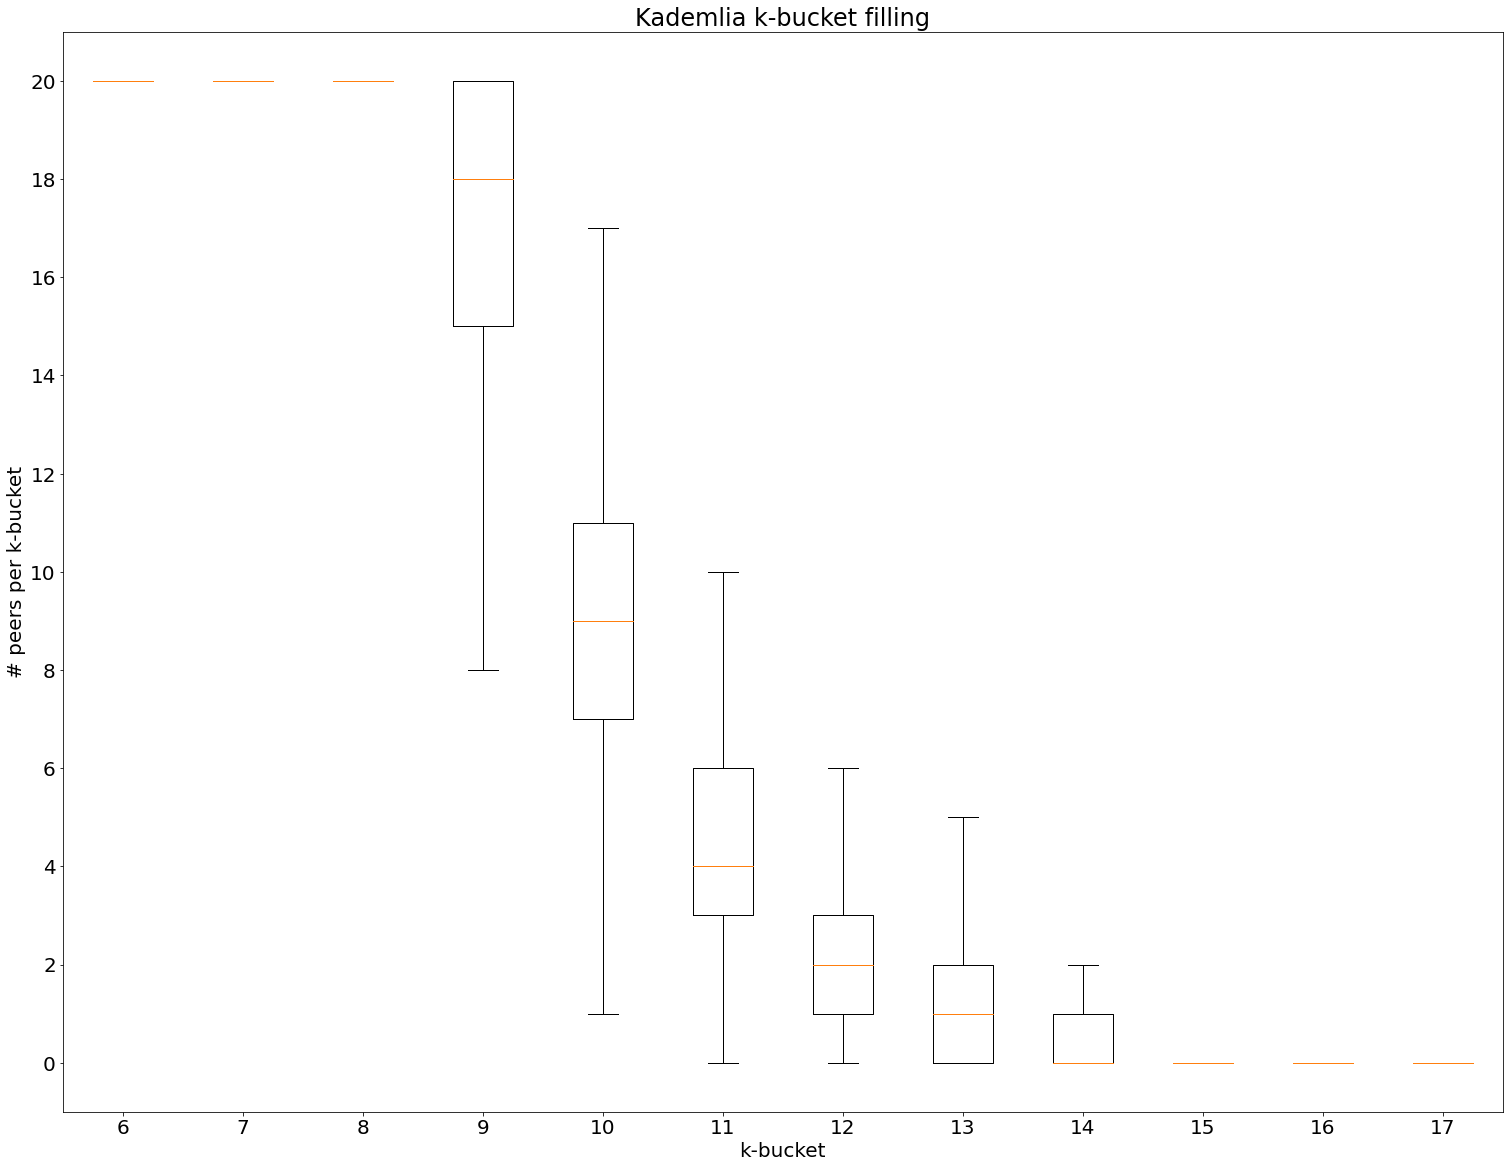

In [121]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(buckets[6:18], positions=range(6,18), showfliers=False)

plt.xlabel("k-bucket")
plt.ylabel("# peers per k-bucket")
plt.grid(False)

plt.title("Kademlia k-bucket filling")

plt.savefig("plots/kbucket-filling-distribution.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [13]:
dead_in_bucket = [0]*257
count_in_bucket = [0]*len(dead_in_bucket)
count=0
for peer in peers:
    if not peers[peer].alive:
        continue
    count += 1
    for bucket in range(len(peers[peer].buckets)):
        count_in_bucket[bucket] += len(peers[peer].buckets[bucket])
        for neighbor in peers[peer].buckets[bucket]:
            if not neighbor.alive:
                dead_in_bucket[bucket] += 1


In [14]:
dead_in_bucket_avg = [v/len(peers) for v in dead_in_bucket]
avg_in_bucket = [v/count for v in count_in_bucket]
dead_in_bucket_ratio = [dead_in_bucket[i]/count_in_bucket[i] if count_in_bucket[i] > 0 else 0 for i in range(len(dead_in_bucket))]

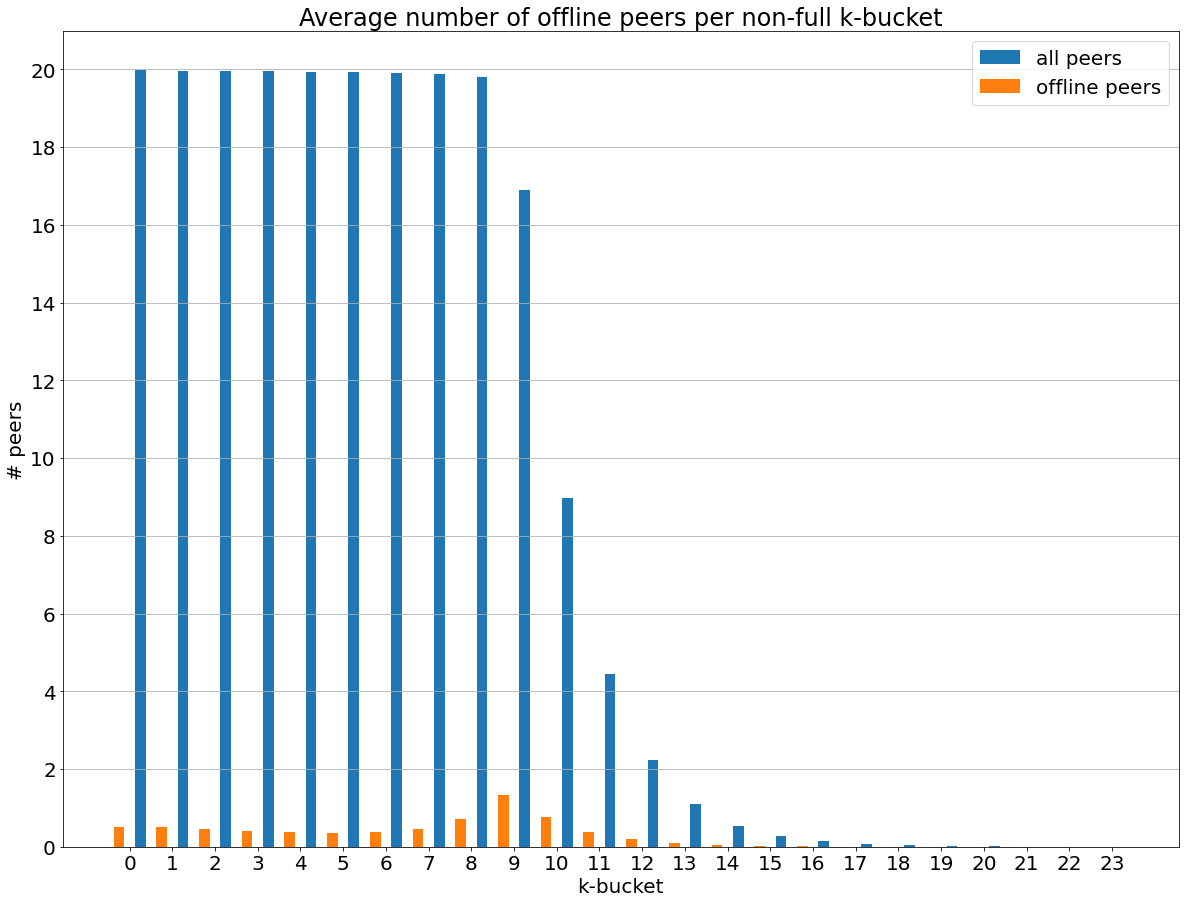

In [105]:
fig = plt.figure(figsize=(20,15), facecolor='white')
max_val = 24
plt.xticks(range(0, max_val, 1))
plt.yticks(range(0,21,2))

plt.grid(axis='y')
plt.bar([i+0.25 for i in range(0,max_val)], avg_in_bucket[0:max_val], width=0.25, label='all peers')
plt.bar([i-0.25 for i in range(0,max_val)], dead_in_bucket_avg[0:max_val], width=0.25, label='offline peers')

#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)
plt.legend()

plt.title('Average number of offline peers per non-full k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("# peers")

plt.savefig('plots/missing-peers-in-non-full-kbuckets.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')


plt.show()

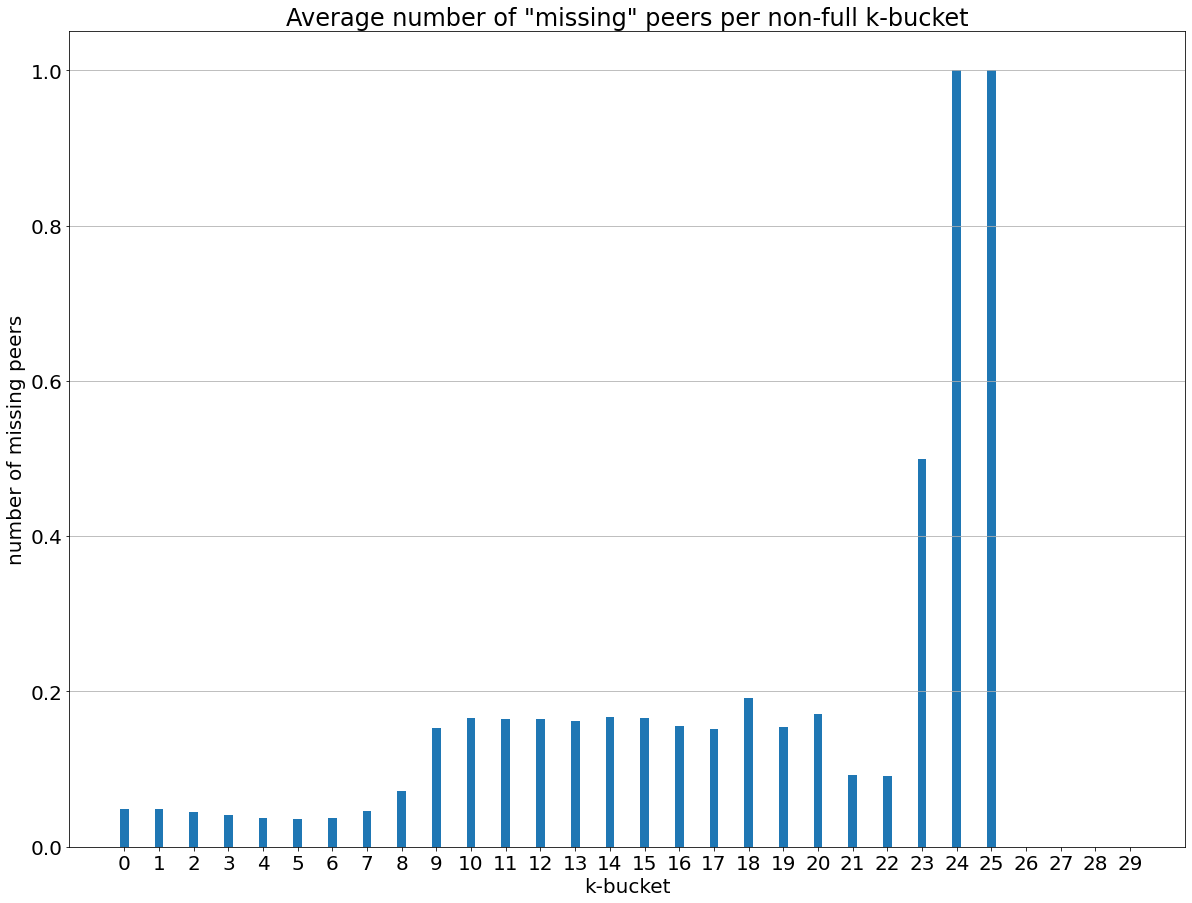

In [81]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.xticks(range(0, 30, 1))

plt.grid(axis='y')
plt.bar(range(0,30), dead_in_bucket_ratio[0:30], width=0.25)
#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)

plt.title('Average number of "missing" peers per non-full k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("number of missing peers")

plt.show()

In [17]:
t = Trie()
for p in peers:
    t.add(bytes_to_bitstring(peers[p].key), metadata=peers[p])

## 20 closest peers CDF

In [18]:
alive_trie = Trie()
for p in alive_peers:
    alive_trie.add(bytes_to_bitstring(alive_peers[p].key), metadata=alive_peers[p])

In [19]:
neighbors20 = []
for p in alive_peers:
    peers20 = alive_trie.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:]
    # peerset20 = t.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:] # that is wrong
    # we should test the actual neighbors e.g peers[p].neighbors
    neighbors = [peers[p].neighbors[n].key for n in peers[p].neighbors]
    
    count = 0
    for p in peers20:
        if p.key in neighbors:
            count+=1
    neighbors20.append(count)


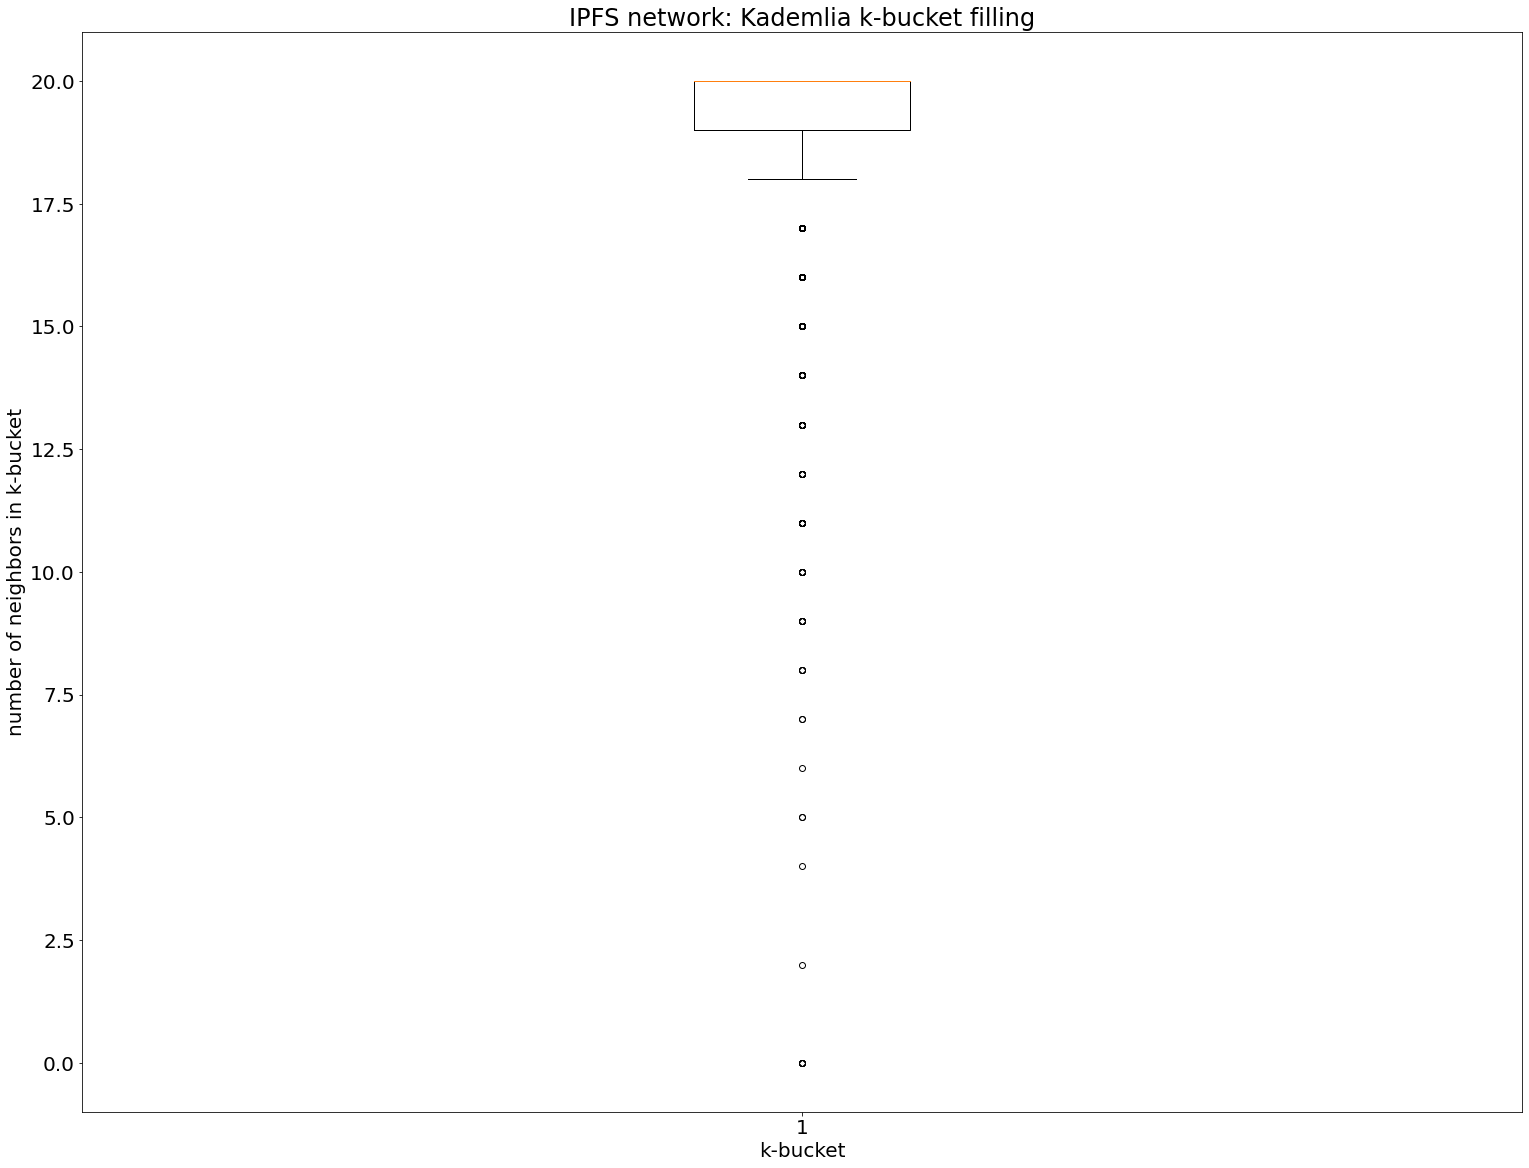

In [82]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
#plt.yticks(range(0, 21, 2))

plt.xlabel("k-bucket")
plt.ylabel("number of neighbors in k-bucket")

plt.title("IPFS network: Kademlia k-bucket filling")

_= ax.boxplot(neighbors20)
 
# show plot
plt.show()

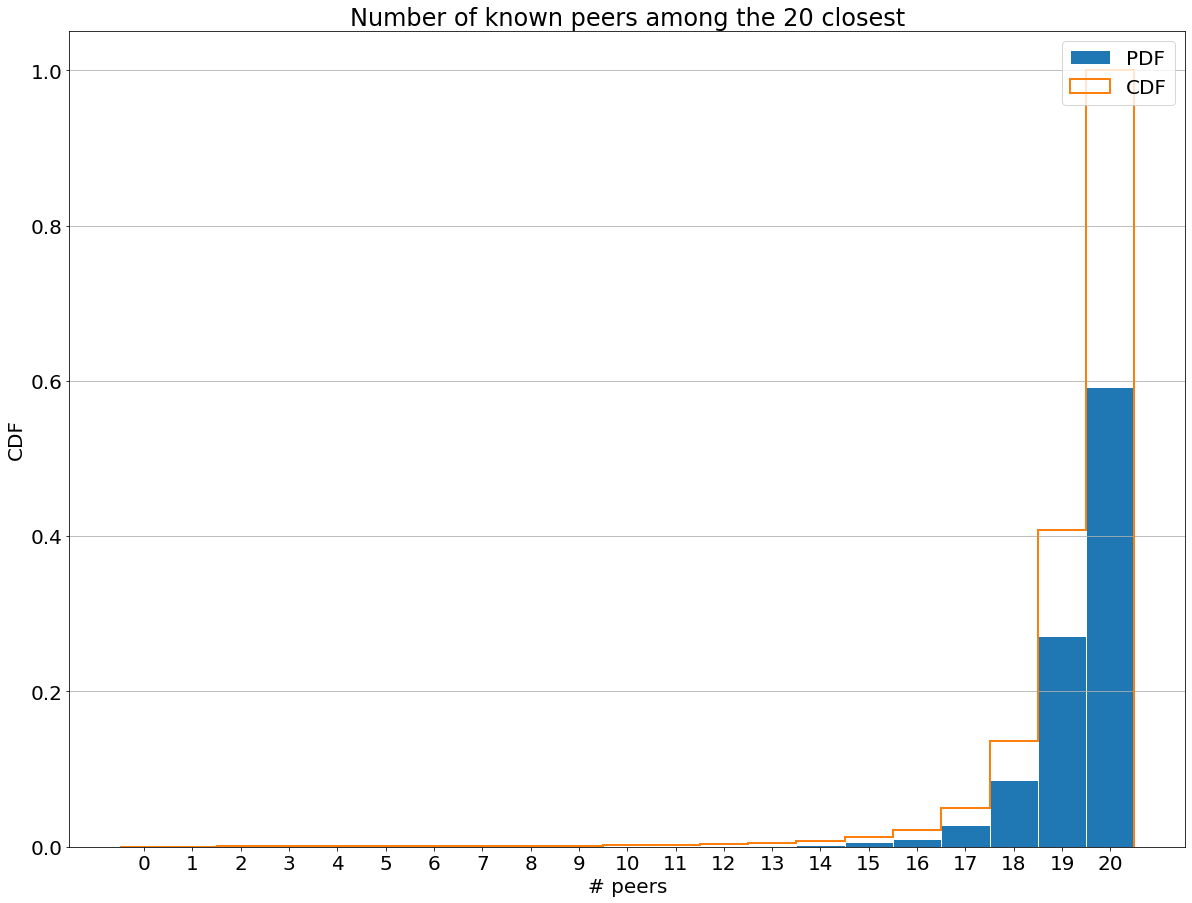

In [134]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.hist(neighbors20,bins=[x - 0.5 for x in range(0,22)],density=True, linewidth=1, edgecolor="white", label='PDF')
plt.hist(neighbors20,bins=[x - 0.5 for x in range(0,22)], density=True, cumulative=True, label='CDF', histtype='step', linewidth=2)
plt.grid(axis='y')
plt.xlabel("# peers")
plt.ylabel("CDF")
plt.xticks(range(0,21))
plt.legend()
plt.title("Number of known peers among the 20 closest")
plt.savefig('plots/known-peers-among-20-closest.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [167]:
pdf = [neighbors20.count(x)/len(neighbors20) for x in range(21)]
cdf = [sum(pdf[:i+1]) for i in range(len(pdf))]

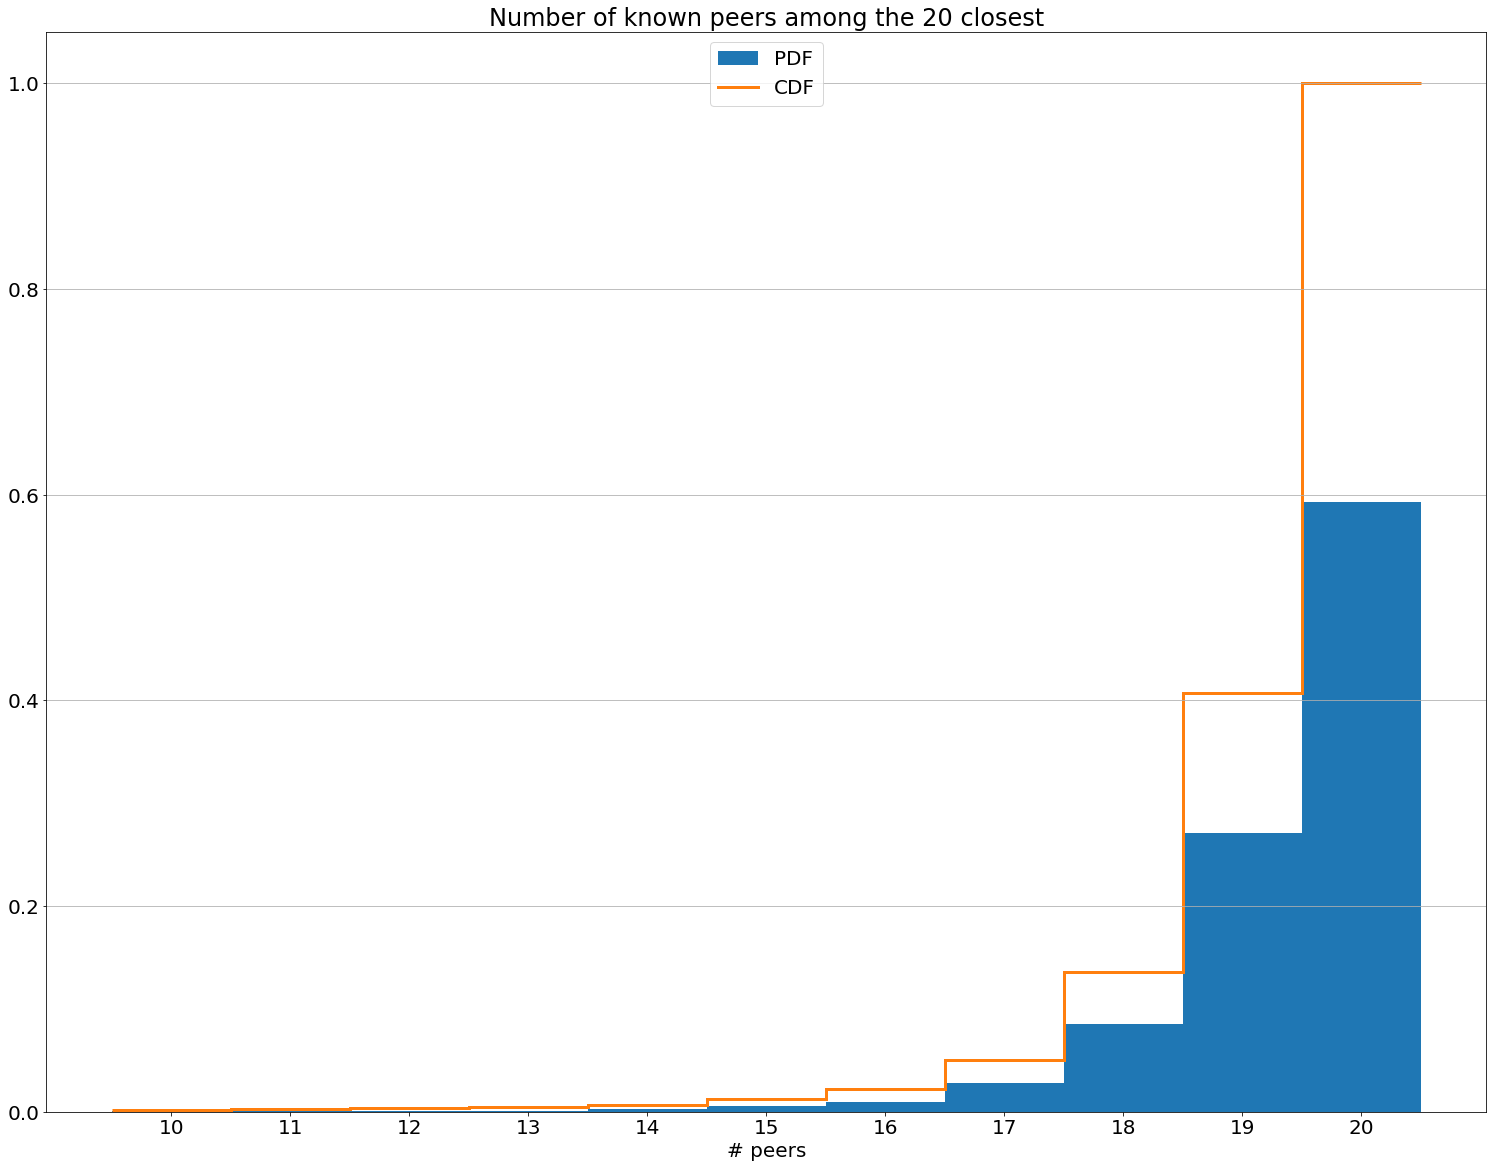

In [189]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

ax.stairs(values=pdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='PDF', fill=True)
ax.stairs(values=cdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='CDF', linewidth=3, baseline=None)

plt.grid(axis='y')
plt.xlabel("# peers")
plt.xticks(range(10, 21))
plt.legend(loc='upper center')
plt.title("Number of known peers among the 20 closest")
plt.savefig('plots/known-peers-among-20-closest.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()


In [23]:
levels=7
density=[0]*2**levels

In [24]:
for i in range(2**levels):
    path="{0:b}".format(i)
    path='0'*(levels-len(path))+path
    
    density[i]=t.find_trie(path).size


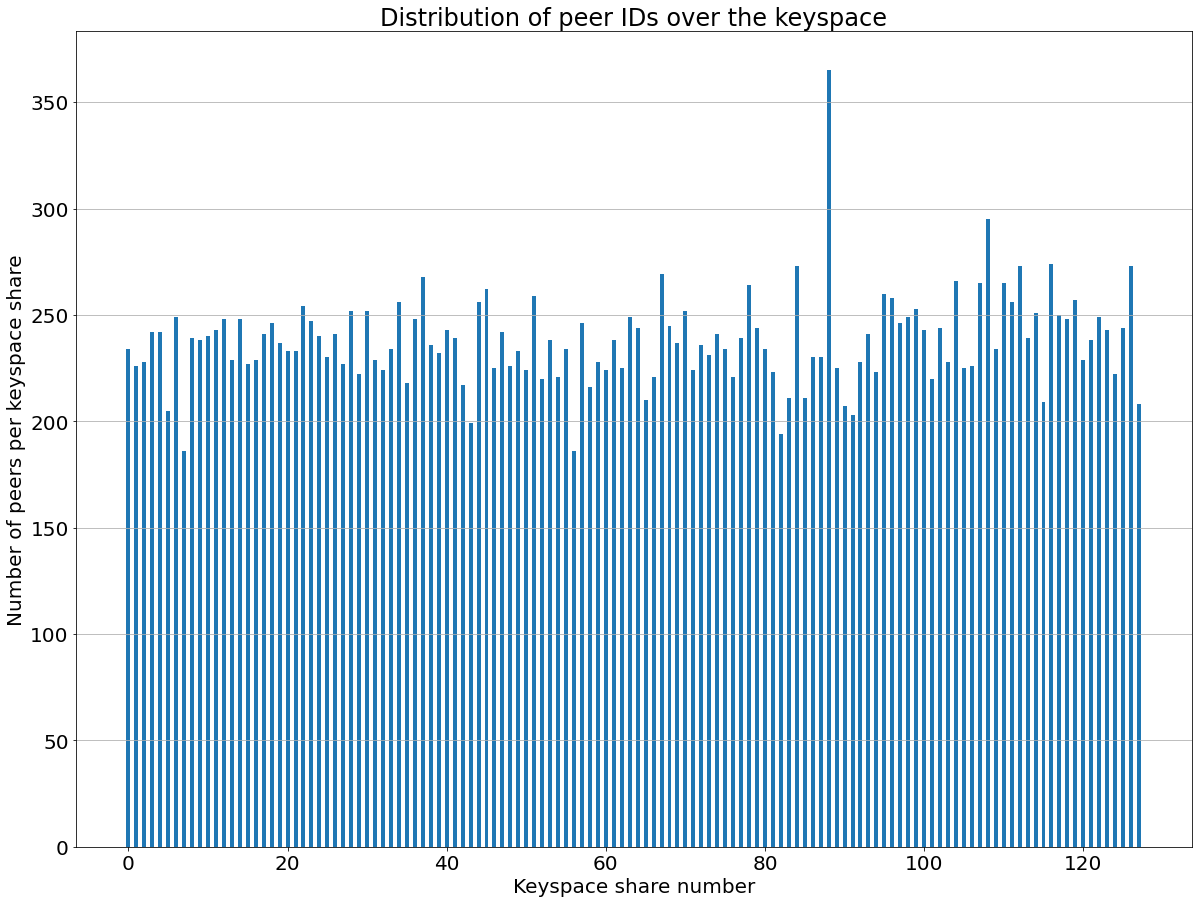

In [123]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace share number")
plt.ylabel("Number of peers per keyspace share")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [49]:
non_full_buckets = [0] * 255
missing_peers_in_bucket = [0] * len(non_full_buckets)

c0 = 0
c1 = 0

for p in alive_peers:
    for bid in range(len(non_full_buckets)):
        blen = len(alive_peers[p].buckets[bid])
        if blen < 20:
            non_full_buckets[bid] += 1
            
            # bucket number = CPL
            key = bytes_to_bitstring(alive_peers[p].key)
            path = key[:bid]+str(1-int(key[bid+1]))
            
            subtrie = alive_trie.find_trie(path)
            if subtrie is None:
                # we want to find out if it is included in a path
                # or if it is not present at all in the trie
                subtrie = alive_trie
                while len(subtrie.key) < len(path):
                    subtrie = subtrie.branch[int(path[len(subtrie.key)])]
                    m = min(len(path),len(subtrie.key)+1)
                    if subtrie.key[:m] != path[:m]:
                        # subtrie doesn't exist
                        subtrie = None
                        break
                        
            if bid > 250 and subtrie is None:
                c0+=1
            elif bid > 250 and subtrie is not None:
                c1+=1
                    
            if subtrie is not None and subtrie.size > blen:
                missing_peers_in_bucket[bid] += min(subtrie.size,20) - blen
                
print(c0, c1)

62280 0


In [50]:
missing_peers_per_bucket = [missing_peers_in_bucket[i]/len(alive_peers) for i in range(len(non_full_buckets))]                
missing_peers_per_non_full_bucket = [missing_peers_in_bucket[i]/non_full_buckets[i] if non_full_buckets[i] > 0 else 0 for i in range(len(non_full_buckets))]

In [27]:
t2 = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t2.add(int_to_bitstring(i, 4))
    
path = "00"
    
subtrie = t2.find_trie(path)
if subtrie is None:
    # we want to find out if it is included in a path
    # or if it is not present at all in the trie
    subtrie = t2
    while len(subtrie.key) < len(path):
        subtrie = subtrie.branch[int(path[len(subtrie.key)])]
        m = min(len(path),len(subtrie.key))
        if subtrie.key[:m] != path[:m]:
            # subtrie doesn't exist
            subtrie = None
            break

if subtrie is not None:
    print(subtrie)
    print(subtrie.branch)
    print(subtrie.size)
else:
    print("not found")

(0010 / 001 \ 0011)
[(0010), (0011)]
2


In [51]:
missing_peers_per_bucket

[0.025048169556840076,
 0.0371868978805395,
 0.046499678869621065,
 0.05054592164418754,
 0.06287732819524727,
 0.07578676942838793,
 0.09248554913294797,
 0.11560693641618497,
 0.19858702633269107,
 0.6551059730250481,
 0.738728323699422,
 0.6438021836865767,
 0.4754656390494541,
 0.32318561335902374,
 0.19961464354527939,
 0.11316634553628774,
 0.0542068079640334,
 0.026718047527296084,
 0.014707771355170198,
 0.007193320488118176,
 0.00449582530507386,
 0.0019267822736030828,
 0.0003853564547206166,
 0.0,
 0.0,
 0.00012845215157353886,
 0.0003853564547206166,
 0.00012845215157353886,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

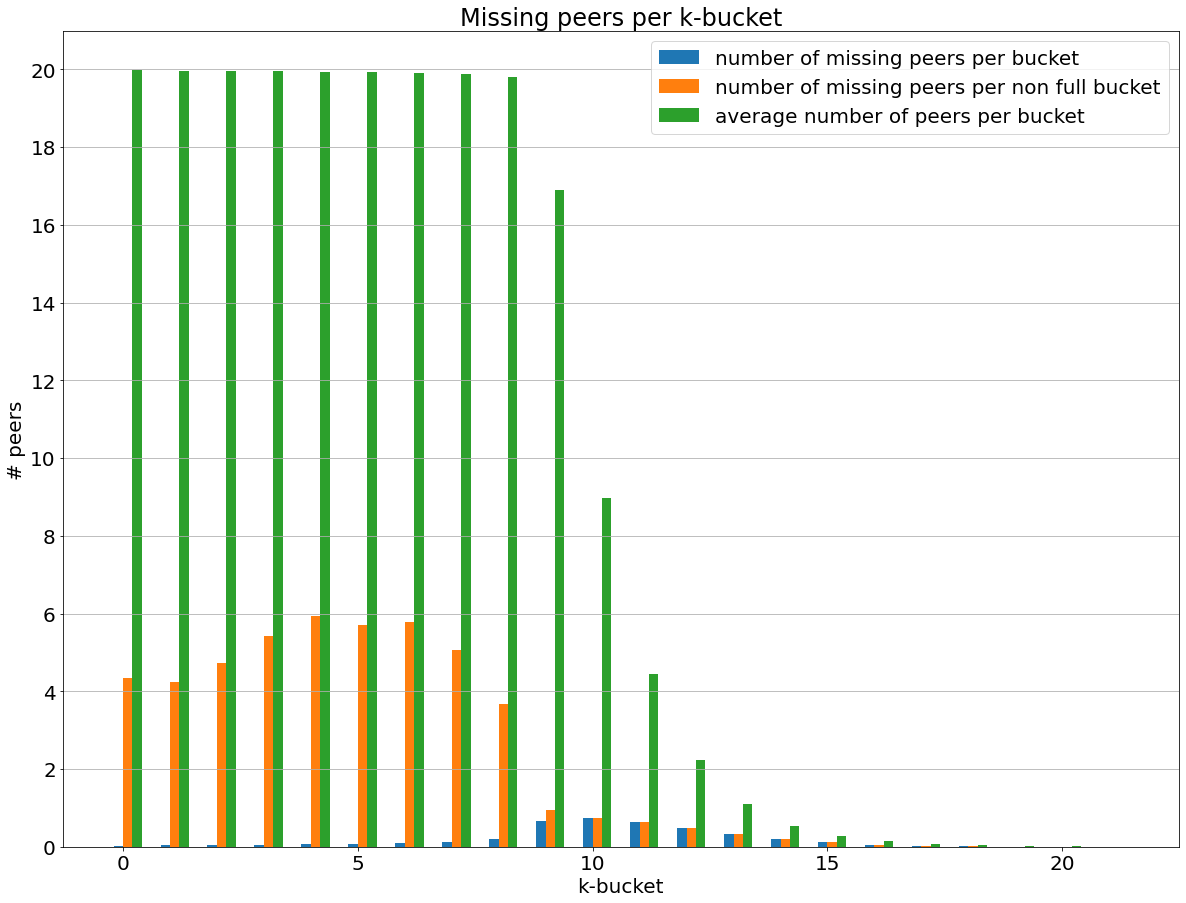

In [124]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.yticks(range(0, 22, 2))

plt.grid(axis='y')
plt.bar([x - 0.1 for x in range(22)], missing_peers_per_bucket[:22], width=0.2, label='number of missing peers per bucket')
plt.bar([x + 0.1 for x in range(22)], missing_peers_per_non_full_bucket[:22], width=0.2, label='number of missing peers per non full bucket')
plt.bar([x + 0.3 for x in range(22)], avg_in_bucket[:22], width=0.2, label='average number of peers per bucket')

#plt.bar(range(22), missing_peers_per_non_full_bucket[:22], width=0.25)

#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)

plt.title('Missing peers per k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("# peers")
plt.legend()

plt.savefig('plots/missing-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [87]:
closest_peers = [[] for _ in range(20)]

for p in alive_peers:
    # get 20 closest neighbors from the trie
    closest20 = alive_trie.n_closest(bytes_to_bitstring(peers[p].key), 21)[1:]
    
    for i in range(len(closest20)):
        d=xor_distance(peers[p].key, closest20[i].key)
        bucket=bucket_number_for_distance(d)

        closest_peers[i].append(bucket)


In [88]:
data = []
for line in closest_peers:
    data.append(sum(line)/len(line))

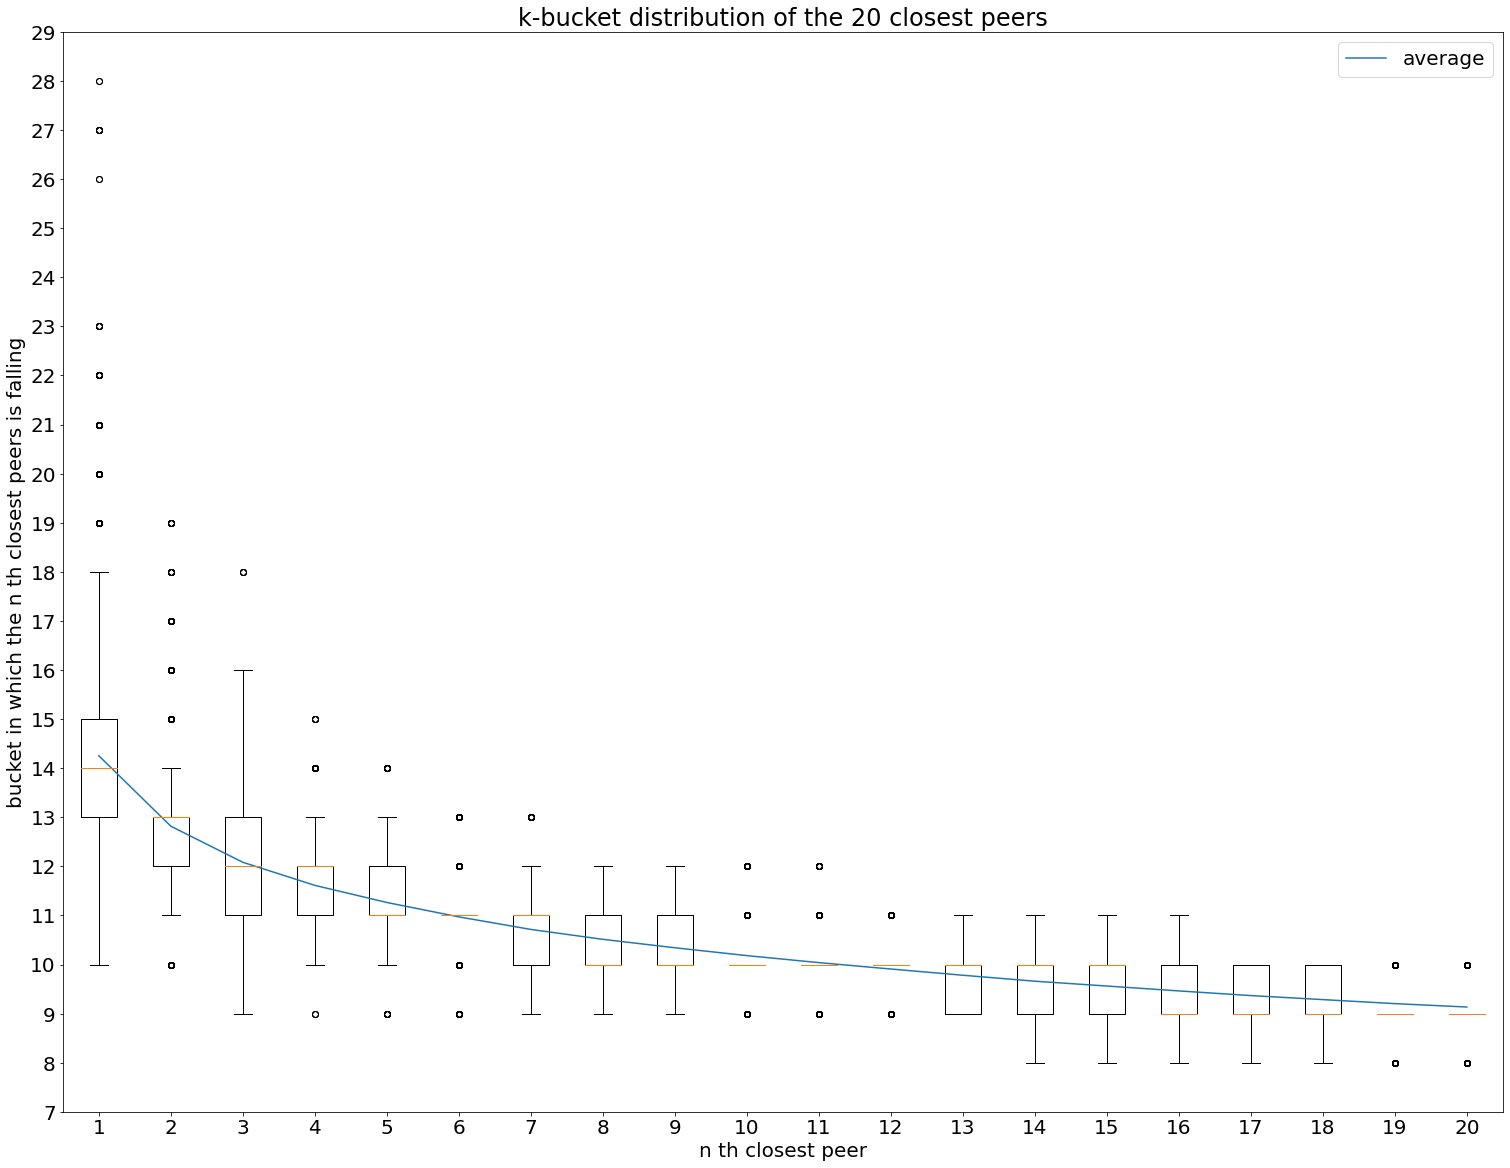

In [125]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

plt.yticks(range(5, 31, 1))

plt.grid(False)
plt.xlabel("n th closest peer")
plt.ylabel("bucket in which the n th closest peers is falling")

#plt.title("IPFS network: Kademlia k-bucket filling")

bp = ax.boxplot(closest_peers)
ax.plot(range(1,21),data, label='average')

plt.legend()
plt.title("k-bucket distribution of the 20 closest peers")
 
plt.savefig('plots/kbucket-distribution-20-closest-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [90]:
xClosest = []
for i in range(len(closest_peers)):
    total=sum([closest_peers[i].count(b) for b in range(9,26)])
    xClosest.append([closest_peers[i].count(b)/total for b in range(9,26)])


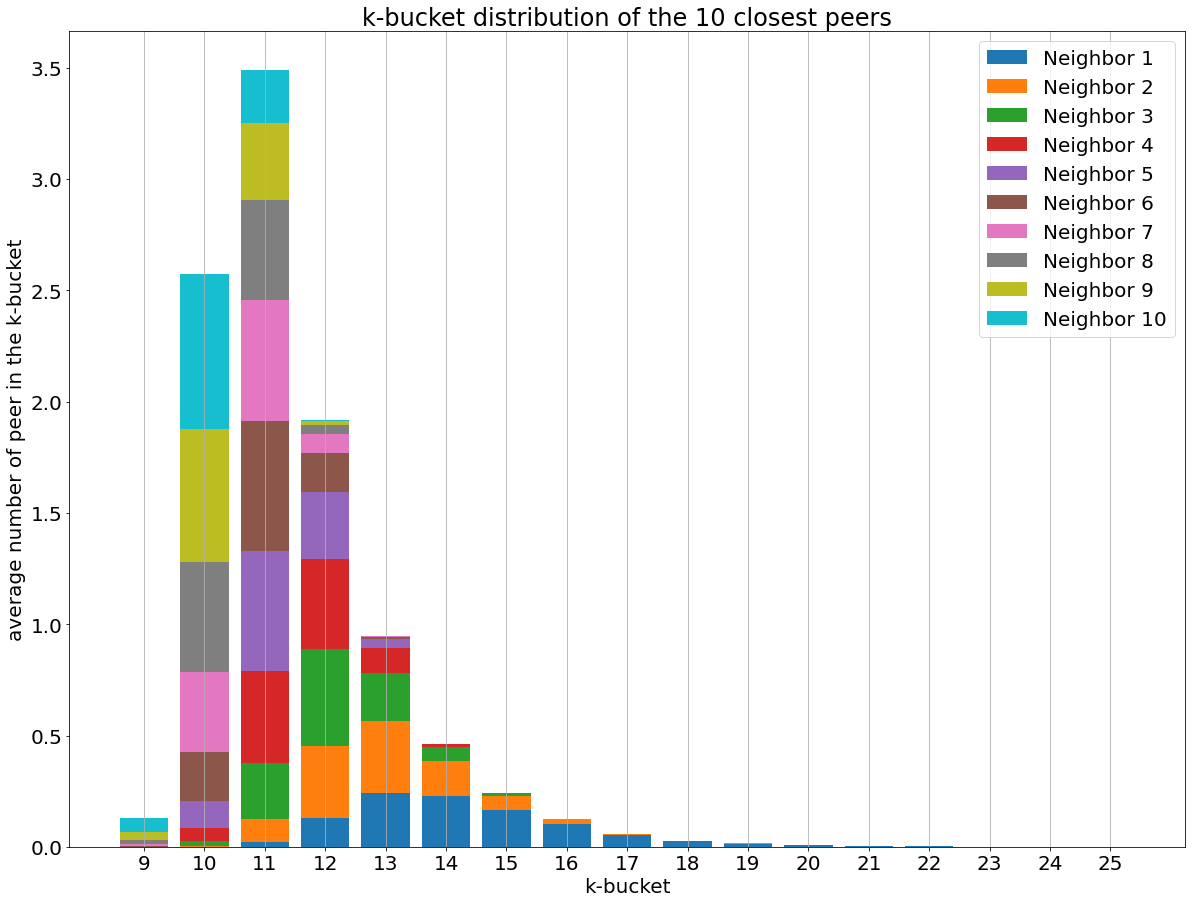

In [126]:
fig, ax = plt.subplots(figsize=(20,15), facecolor='white')

plt.xticks(range(9, 26, 1))

cumsum=[0 for _ in range(9,26)]

for i in range(10):
    label="Neighbor "+str(i+1)
    ax.bar(range(9,26), xClosest[i], bottom=cumsum, label=label)        
    cumsum = [cumsum[j]+xClosest[i][j] for j in range(len(cumsum))]
    
ax.legend()
plt.grid(axis='x')

plt.title("k-bucket distribution of the 10 closest peers")
plt.xlabel("k-bucket")
plt.ylabel("average number of peer in the k-bucket")
plt.savefig('plots/distribution-10-closest-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()